数据集准备

In [1]:
%matplotlib inline
import numpy as np
import os
from PIL import Image
img_size = 50
channel=3
list_Burke = os.listdir('Burke/')  #glob.glob('*.jpg')
list_Ticon = os.listdir('Ticon/')
data_Burke = np.zeros(dtype=np.uint8,shape=(len(list_Burke),img_size,img_size,channel))
data_Ticon = np.zeros(dtype=np.uint8,shape=(len(list_Ticon),img_size,img_size,channel))

for i in range(len(list_Burke)):
    im = Image.open('Burke/'+list_Burke[i])
    im=im.resize((img_size,img_size))
    data_Burke[i,:,:,:]=np.array(im)
for i in range(len(list_Ticon)):
    im = Image.open('Ticon/'+list_Ticon[i])
    im=im.resize((img_size,img_size))
    data_Ticon[i,:,:,:]=np.array(im)

In [2]:
import keras
from sklearn.model_selection import train_test_split
data = np.concatenate((data_Burke,data_Ticon),axis=0)
print(data.shape)
label = np.zeros(dtype=np.int,shape=(len(list_Burke)+len(list_Ticon)))
label[:len(list_Burke)]=1  #指定Burke的标签为1，Ticon标签为0
label=keras.utils.to_categorical(label,num_classes=2) #to_one_hot
print(label.shape)
shuffle_ind = np.random.permutation(len(data))
data1 = data[shuffle_ind]
data1= data1.astype('float')/255
label1 = label[shuffle_ind]
X_train,X_test,y_train,y_test = train_test_split(data1,label1,test_size=0.2)
X_test.shape

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(507, 50, 50, 3)
(507, 2)


(102, 50, 50, 3)

In [3]:
y_train.shape

(405, 2)

可视化数据集

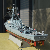

In [4]:
Image.fromarray(data[233])

In [5]:
im1 = Image.open('Burke/'+list_Burke[0])
import numpy as np
im2ar = np.array(im1)


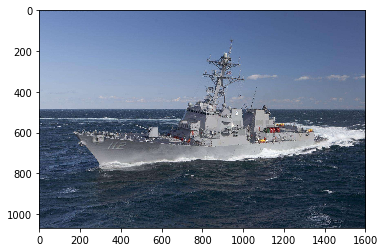

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(im2ar)

## 第一部分：构建多层ＣＮＮ进行训练: 0.8137

构建模型

In [7]:
input_shape=(img_size,img_size,channel)

In [8]:
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
def create_model():
    model=Sequential()
    model.add(Conv2D(filters=16,kernel_size=3,strides=1,input_shape=input_shape,activation='relu',name='layer_conv1'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(filters=32,kernel_size=3,strides=1,activation='relu',name='layer_conv2'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(filters=64,kernel_size=3,strides=1,activation='relu',name='layer_conv3'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(filters=64,kernel_size=3,strides=1,activation='relu',name='layer_conv4'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(units=1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=2,activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics = ['accuracy'])
    return model

In [9]:
model = create_model()
model.fit(X_train,y_train,batch_size=32,epochs=25)

Epoch 1/25
405/405 [==============================] - 2s 4ms/step - loss: 0.6970 - acc: 0.5062
Epoch 2/25
405/405 [==============================] - 0s 247us/step - loss: 0.6927 - acc: 0.5074
Epoch 3/25
405/405 [==============================] - 0s 247us/step - loss: 0.6936 - acc: 0.4951
Epoch 4/25
405/405 [==============================] - 0s 243us/step - loss: 0.6924 - acc: 0.5296
Epoch 5/25
405/405 [==============================] - 0s 273us/step - loss: 0.6923 - acc: 0.5272
Epoch 6/25
405/405 [==============================] - 0s 273us/step - loss: 0.6901 - acc: 0.5309
Epoch 7/25
405/405 [==============================] - 0s 260us/step - loss: 0.6835 - acc: 0.5753
Epoch 8/25
405/405 [==============================] - 0s 288us/step - loss: 0.6772 - acc: 0.5654
Epoch 9/25
405/405 [==============================] - 0s 265us/step - loss: 0.6548 - acc: 0.6284
Epoch 10/25
405/405 [==============================] - 0s 248us/step - loss: 0.6303 - acc: 0.6543
Epoch 11/25
405/405 [==========

In [10]:
model.predict(X_test)[:10]
model.evaluate(X_test,y_test)

102/102 [==============================] - 0s 342us/step


[0.7828200588039324, 0.7254901949097129]

In [11]:
pred=model.predict(X_test)
np.mean(np.argmax(pred,axis=1)==np.argmax(y_test,axis=1))

0.7254901960784313

进一步：使用cross_validation

In [12]:
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV
import time
start_time = time.time()
# estimator=[]
# estimator.append(('min_max_scale',MinMaxScaler()))
# estimator.append(('cnn',KerasClassifier(build_fn=create_model,nb_epoch=10,batch_size=32)))
# ppline=Pipeline(estimator)
clf = KerasClassifier(build_fn=create_model)
batch_size = [4,32]
epochs = [5, 30]
param_grid = dict(batch_size = batch_size,epochs = epochs)
grid = GridSearchCV(clf,param_grid,n_jobs=-1,cv=3)

cv_results = cross_val_score(grid,data1,label1)
end_time = time.time()

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Epoch 1/5
Epoch 1/5
Epoch 1/30
Epoch 1/30
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30


KeyboardInterrupt: 

In [13]:
results

NameError: name 'results' is not defined

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
X_low_d=pca.fit_transform(X_train_scaled)

NameError: name 'X_train_scaled' is not defined

In [ ]:
plt.scatter(X_low_d[y_train_compact==0,0],X_low_d[y_train_compact==0,1])

## 第二部分：使用svm：0.6568

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# clf = SVC(kernel='rbf',C=500,coef0=1) #0.666
clf = SVC(kernel='linear',C=0.1)
y_train_compact = np.argmax(y_train,axis=1)
y_train_compact.shape
X_train_svm = X_train.reshape(X_train.shape[0],-1)
scl = MinMaxScaler()
X_train_scaled = scl.fit_transform(X_train_svm)
clf.fit(X_train_scaled,y_train_compact)
prediction=clf.predict(X_test.reshape(X_test.shape[0],-1))
np.mean(prediction==np.argmax(y_test,axis=1))

In [ ]:
np.argmax(y_test,axis=1).shape

In [ ]:
prediction

In [ ]:
np.argmax(y_test,axis=1)

In [ ]:
y_train.shape

## 第三部分：使用VGG16预训练模型进行迁移学习:0.9804

In [1]:
%matplotlib inline
import numpy as np
import os
from PIL import Image
img_size = 224
channel=3
list_Burke = os.listdir('Burke/')  #glob.glob('*.jpg')
list_Ticon = os.listdir('Ticon/')
list_Evalate = os.listdir('Test_set/')
data_Burke = np.zeros(dtype=np.uint8,shape=(len(list_Burke),img_size,img_size,channel))
data_Ticon = np.zeros(dtype=np.uint8,shape=(len(list_Ticon),img_size,img_size,channel))
data_Evaluate = np.zeros(dtype=np.uint8,shape=(len(list_Evalate),img_size,img_size,channel))

for i in range(len(list_Burke)):
    im = Image.open('Burke/'+list_Burke[i])
    im=im.resize((img_size,img_size))
    data_Burke[i,:,:,:]=np.array(im)
for i in range(len(list_Ticon)):
    im = Image.open('Ticon/'+list_Ticon[i])
    im=im.resize((img_size,img_size))
    data_Ticon[i,:,:,:]=np.array(im)
for i in range(len(list_Evalate)):
    im = Image.open('Test_set/'+list_Evalate[i])
    im=im.resize((img_size,img_size))
    data_Evaluate[i,:,:,:]=np.array(im)
import keras
from sklearn.model_selection import train_test_split
data = np.concatenate((data_Burke,data_Ticon),axis=0)
print(data.shape)
label = np.zeros(dtype=np.int,shape=(len(list_Burke)+len(list_Ticon)))
label[:len(list_Burke)]=1  #指定Burke的标签为1，Ticon标签为0
label=keras.utils.to_categorical(label,num_classes=2) #to_one_hot
print(label.shape)
shuffle_ind = np.random.permutation(len(data))
data1 = data[shuffle_ind]
data1= data1.astype('float')/255
data_Evaluate = data_Evaluate.astype('float')/255
label1 = label[shuffle_ind]
X_train,X_test,y_train,y_test = train_test_split(data1,label1,test_size=0.2)
X_test.shape

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(507, 224, 224, 3)
(507, 2)


(102, 224, 224, 3)

In [2]:
from keras import Sequential
from keras.applications import VGG16
from keras.layers import Dense,Conv2D,ZeroPadding2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import SGD
from sklearn.metrics import log_loss,accuracy_score

def vgg16_model(img_row, img_col, channel, num_classes):
    model = Sequential()
    # model.add(ZeroPadding2D(1, 1), input_shape = (img_row, img_col, channel))
    model.add(Conv2D(64, (3, 3), padding='same',input_shape=(img_row,img_col,channel), activation='relu')) #224
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

    model.add(MaxPooling2D((2,2), strides=(2,2))) #112 注意步长是2才能下采样！
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2))) #56
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2))) #28
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2))) #14
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2))) #7


    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    ## 加载预训练模型在ImageNet上训练好的权重
    model.load_weights('/home/fp/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5')
    ## 去掉最后一层FC，用自己的代替
    model.layers.pop() #去掉最后一层
    model.outputs = [model.layers[-1].output]  #加中括号将多个结果直接放进一个列表
    model.layers[-1].outbound_nodes = []  ##???????????????
    model.add(Dense(num_classes, activation='sigmoid'))

    ## 保持前十层权重不变（freeze）
    for layer in model.layers[:10]:
        layer.trainable = False

    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    return model

if __name__ == '__main__':
    img_rows, img_cols = 224, 224
    channel = 3
    num_classes = 2
    batch_size = 16
    epoch = 10
    model = vgg16_model(img_rows, img_cols, channel, num_classes)
    print('load pretrained model weights.....')
    model.fit(X_train, y_train, shuffle=True,
              epochs=epoch, batch_size=batch_size,
              verbose=1)
    prediction_test = model.predict(X_test, batch_size = batch_size, verbose=1)
#     accuracy = accuracy_score(y_test, prediction_test)
    test_accuracy=np.mean(np.argmax(prediction_test,axis=1)==np.argmax(y_test,axis=1))
    print('使用VGG16预训练模型的测试结果为：　{:.4f}'.format(test_accuracy))

load pretrained model weights.....
Epoch 1/10
405/405 [==============================] - 5s 12ms/step - loss: 0.9753 - acc: 0.4889
Epoch 2/10
405/405 [==============================] - 3s 7ms/step - loss: 0.6936 - acc: 0.5877
Epoch 3/10
405/405 [==============================] - 3s 7ms/step - loss: 0.5767 - acc: 0.7136
Epoch 4/10
405/405 [==============================] - 3s 8ms/step - loss: 0.4245 - acc: 0.8111
Epoch 5/10
405/405 [==============================] - 3s 7ms/step - loss: 0.2495 - acc: 0.9074
Epoch 6/10
405/405 [==============================] - 3s 7ms/step - loss: 0.1679 - acc: 0.9309
Epoch 7/10
405/405 [==============================] - 3s 7ms/step - loss: 0.1181 - acc: 0.9605
Epoch 8/10
405/405 [==============================] - 3s 7ms/step - loss: 0.0885 - acc: 0.9704
Epoch 9/10
405/405 [==============================] - 3s 7ms/step - loss: 0.1929 - acc: 0.9346
Epoch 10/10
102/102 [==============================] - 1s 7ms/step
使用VGG16预训练模型的测试结果为：　0.9510


In [3]:
import matplotlib.pyplot as plt
def plot_dataset(data,label,pred):
    num_grids=3
    fig,axis = plt.subplots(num_grids,num_grids)
    for i,ax in enumerate(axis.flat):
        im = data[i]
        lb = np.argmax(label[i],axis=0)
        prd = np.argmax(pred[i],axis=0)
        ax.imshow(im)
        ax.set_xlabel('True:'+str(lb)+' Pred:'+str(prd))
        ax.set_xticks([])
        ax.set_yticks([])

可视化几个预测结果作为例子

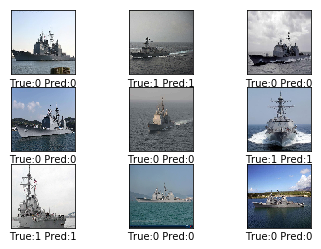

In [4]:
plot_dataset(X_test,y_test,prediction_test)

In [5]:
error_ind = np.argmax(prediction_test,axis=1)!=np.argmax(y_test,axis=1)
error_ind=error_ind.reshape(-1,1)
error_instance=X_test[error_ind.ravel()]

可视化两个错误预测样例

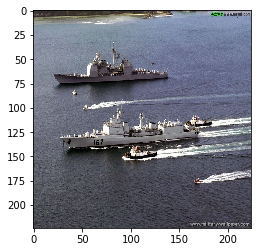

In [6]:
plt.imshow(error_instance[0])

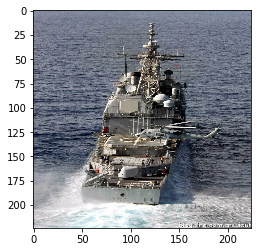

In [7]:
plt.imshow(error_instance[1])

In [8]:
from keras.applications import xception
Xception_bottlenck = xception.Xception()

In [11]:
preds = model.predict(data_Evaluate)

In [17]:
test_tag = np.argmax(preds,axis=1)
#Burke=>1  Ticon=>0

In [ ]:
table=''.maketrans('0','Burke')


In [66]:
ind=test_tag==1
tag=[]
for i,el in enumerate(list(test_tag)):
    if el==1:
        tag.append('Burke')
    elif el==0:
        tag.append('Ticon')

In [68]:
test_tag

array([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [67]:
tag

['Burke',
 'Ticon',
 'Burke',
 'Ticon',
 'Ticon',
 'Ticon',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Ticon',
 'Ticon',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Ticon',
 'Burke',
 'Burke',
 'Ticon',
 'Burke',
 'Burke',
 'Ticon',
 'Burke',
 'Ticon',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Ticon',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Ticon',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Ticon',
 'Burke',
 'Burke',
 'Ticon',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Ticon',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Burke',
 'Ticon',
 'Ticon',
 'Burke',


In [69]:
list_Evalate_name = [list_Evalate[i].lstrip('Unidentified').rstrip('.jpg')+'_'+tag[i]+'.jpg' for i in range(len(list_Evalate))]

In [70]:
list_Evalate_name

['Vessel0122_Burke.jpg',
 'Vessel0019_Ticon.jpg',
 'Vessel0054_Burke.jpg',
 'Vessel0018_Ticon.jpg',
 'Vessel0075_Ticon.jpg',
 'Vessel0111_Ticon.jpg',
 'Vessel0074_Burke.jpg',
 'Vessel0105_Burke.jpg',
 'Vessel0028_Burke.jpg',
 'Vessel0007_Burke.jpg',
 'Vessel0037_Burke.jpg',
 'Vessel0131_Burke.jpg',
 'Vessel0048_Ticon.jpg',
 'Vessel0108_Ticon.jpg',
 'Vessel0136_Burke.jpg',
 'Vessel0068_Burke.jpg',
 'Vessel0072_Burke.jpg',
 'Vessel0138_Burke.jpg',
 'Vessel0008_Burke.jpg',
 'Vessel0004_Ticon.jpg',
 'Vessel0036_Burke.jpg',
 'Vessel0114_Burke.jpg',
 'Vessel0017_Ticon.jpg',
 'Vessel0024_Burke.jpg',
 'Vessel0139_Burke.jpg',
 'Vessel0042_Ticon.jpg',
 'Vessel0006_Burke.jpg',
 'Vessel0046_Ticon.jpg',
 'Vessel0066_Burke.jpg',
 'Vessel0099_Burke.jpg',
 'Vessel0088_Burke.jpg',
 'Vessel0014_Burke.jpg',
 'Vessel0025_Burke.jpg',
 'Vessel0051_Burke.jpg',
 'Vessel0116_Burke.jpg',
 'Vessel0060_Burke.jpg',
 'Vessel0031_Burke.jpg',
 'Vessel0038_Ticon.jpg',
 'Vessel0047_Burke.jpg',
 'Vessel0069_Burke.jpg',


In [76]:
import imageio
import os
for i,img_name in enumerate(list_Evalate):
    os.rename('./Test_set/'+img_name,list_Evalate_name[i])